
Data Mining - MSDS 7331 - Thurs 6:30, Summer 2016

Team 3 (AKA Team Super Awesome):  Sal Melendez, Rahn Lieberman, Thomas Rogers

Github page:
https://github.com/RahnL/DataScience-SMU/tree/master/DataMining

(Note: Code borrowed heavily from Eric Larson's github pages for this class.
https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb)

<hr>

# Data Mining - Mini Lab 1

This lab continues on our exploration and analysis of the BRFSS dataset, which are the results of a phone interviews with approximately 464,000 people in 2014.
All the fields are either likert scales or boolean, with the caveat that almost all of the results contain an extra two values to indicate answers of "Don't Know" or "No Response".  That is, a binary variable may have 4 results.

The first step is importing the data into a Pandas dataframe and clean it up to get our variables of interest.

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame

df = pd.read_csv("data/LLCP2014XPT.txt", sep="\t", encoding = "ISO-8859-1")
df.head()

C:\Users\rahnl\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_FOBTFS,_CRCREC,_AIDTST3,_IMPEDUC,_IMPMRTL,_IMPHOME,RCSBRAC1,RCSRACE1,RCHISLA1,RCSBIRTH
0,1,1,1172014,1,17,2014,1100,2014000001,2014000001,1.0,...,2.0,1.0,2.0,5,1,1,NaN,NaN,NaN,NaN
1,1,1,1072014,1,7,2014,1100,2014000002,2014000002,1.0,...,2.0,2.0,2.0,4,1,1,NaN,NaN,NaN,NaN
2,1,1,1092014,1,9,2014,1100,2014000003,2014000003,1.0,...,2.0,2.0,2.0,6,1,1,NaN,NaN,NaN,NaN
3,1,1,1072014,1,7,2014,1100,2014000004,2014000004,1.0,...,2.0,1.0,2.0,6,3,1,NaN,NaN,NaN,NaN
4,1,1,1162014,1,16,2014,1100,2014000005,2014000005,1.0,...,2.0,1.0,2.0,5,1,1,NaN,NaN,NaN,NaN


## Identifying the Variables of Interest
We are most interested to know how the variables in our dataset relate to self-reported health quality.

We'll work to reduce the dataset and create an imputed variable from the self-reported measure of health.

The question of interest is, "Would You Say in General That Your Health is: (1) excellent, (2) very good, (3) good, (4) fair, (5) poor." Choices 7 and 9 were "unsure" and "not asked", respectively. This is in the GENHLTH variable.

Response variables of interest:

* _AGE80: Calculated continuous variable for imputed age, values above 80 are collapsed. Any respondent over 80 is included in the 80 year old bracket. 
* _INCOMG: Calculated variable for income categories. 
    (1) Less than \$15,000, (2) \$15,000-\$24,999, (3) \$25,000-\$34,9999, (4) \$35,000 - \$49,999, (5) $50,000 or more (9) Don't Know
* _SMOKER3:  Calculated variable for four-level smoker status:  (1)everyday smoker, (2) someday smoker, (3) former smoker, (4) non-smoker, (9) Don't Know


*** RESUBMISSION COMMENTARY ***

We create a new variable, *health*, from the values of the GENHLTH answers. The values for *health* reduce the 5 answers down to a binary, where people are either in good health (excellent, very good, good) or not good health (fair, poor).
With this variable holding our value to predict, we are able to throw out the GENHLTH variable from our dataframe.

Thoughout the whole dataset, variables with answers of "unsure", "refused" and "don't know" were thrown out.

The below cell illustrates this.

In [2]:
df_reduced = df[['GENHLTH','_AGE80','_INCOMG', '_SMOKER3']]

# Cleanup
df_reduced.replace(7,np.nan, inplace=True)  #replace the "refused" answer choice
df_reduced.replace(9, np.nan, inplace=True) #replace the 'Don't Know' choice
df_reduced = df_reduced.dropna() # this drops those that were the refused/don't know.

# this creates a new variable by categorizing GENHLTH into two categories, either good or bad
df_reduced['health'] = pd.cut(df_reduced.GENHLTH,[0,2,5],2,labels=[1,0]) 

# **** THIS WAS MISSING IN ORIGINAL SUBMISSION 
del df_reduced['GENHLTH']
# ****  END MISSING

df_reduced.info()
df_reduced.head()
# Genhlth, _incomg, _smoker3 are all categorical and integer already, so one-hot-encoding is not needed.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380915 entries, 0 to 464663
Data columns (total 4 columns):
_AGE80      380915 non-null int64
_INCOMG     380915 non-null float64
_SMOKER3    380915 non-null float64
health      380915 non-null category
dtypes: category(1), float64(2), int64(1)
memory usage: 12.0 MB


C:\Users\rahnl\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rahnl\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,_AGE80,_INCOMG,_SMOKER3,health
0,61,5.0,3.0,0
1,73,2.0,4.0,0
2,52,5.0,3.0,1
3,67,3.0,4.0,0
4,67,2.0,4.0,0


## Training And Testing

Threefold cross validation, using 80% of data as training.

*** RESUBMISSION COMMENTARY ***

Below, we setup our training and testing data to do three-fold validation, using 80% of the dataset for training and 20% for testing.

*cv_object* holds the 3 "folds" of our dataset.

In [11]:
from sklearn.cross_validation import ShuffleSplit

#... setup x, y
if '_Age80' in df_reduced:
    y = df_reduced['health'].values # get the labels we want
    del df_reduced['health'] # get rid of the class label

X = df_reduced.values # use everything else to predict!

# do the cross validation
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)
print (cv_object)

ShuffleSplit(380915, n_iter=3, test_size=0.2, random_state=None)


## Regression 

Now that the data is loaded into memory, we'll do a logistic regression.

*** RESUBMISSION COMMENTARY ***

We want to try different penalties to see how they affect the accuracy.  We will do this by looping through
different penalties, and comparing the accuracy in each confusion matrix to see which does better.



In [13]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
import datetime

# *** RESUBMISSION COMMENTARY ***
# We are going to try each of the different penalties to see how it does.

penalties = ('l1', 'l2')
for p in penalties:
    print '\n\nNow testing penalty:', p
    
    lr_clf = LogisticRegression(penalty=p, C=1.0, class_weight=None) # get object

    iter_num = 0
    accuracy = 0

    # the indices are the rows used for training and testing in each iteration
    for train_indices, test_indices in cv_object: 
        X_train = X[train_indices]
        y_train = y[train_indices]

        X_test = X[test_indices]
        y_test = y[test_indices]

        # train the reusable logisitc regression model on the training data
        lr_clf.fit(X_train,y_train)  # train object
        y_hat = lr_clf.predict(X_test) # get test set predictions

        # now let's get the accuracy and confusion matrix for this iterations of training/testing
        acc = mt.accuracy_score(y_test,y_hat)
        conf = mt.confusion_matrix(y_test,y_hat)
        print "====Iteration",iter_num," ===="
        print "accuracy", acc
        print "confusion matrix\n",conf
        iter_num+=1
        accuracy = accuracy + acc

    print ('\nAverage accuracy: ', accuracy/iter_num)



Now testing penalty: l1
====Iteration 0  ====
accuracy 0.649318089338
confusion matrix
[[21194 15796]
 [10920 28273]]
====Iteration 1  ====
accuracy 0.650827612459
confusion matrix
[[21418 15826]
 [10775 28164]]
====Iteration 2  ====
accuracy 0.649094942441
confusion matrix
[[21277 15777]
 [10956 28173]]
('\nAverage accuracy: ', 0.64974688141273862)


Now testing penalty: l2
====Iteration 0  ====
accuracy 0.649514983658
confusion matrix
[[21415 15802]
 [10899 28067]]
====Iteration 1  ====
accuracy 0.650184424347
confusion matrix
[[21407 15684]
 [10966 28126]]
====Iteration 2  ====
accuracy 0.649711877978
confusion matrix
[[21408 15752]
 [10934 28089]]
('\nAverage accuracy: ', 0.64980376199414558)


Notice the last line above, giving the average accuracy for all the iterations.

*** RESUBMIT COMMENTARY ***

L1 and L2 both give about the same accuracy, 65%.

We are going to repeat this, using L2, but change the class_weight variable to see if it makes a difference.
Valid values are shown in the list below.


In [28]:
classweight = (None, 'balanced')
for c in classweight:
    print '\n\nNow testing weight:', c
    
    lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=c) # get object

    iter_num = 0
    accuracy = 0

    # the indices are the rows used for training and testing in each iteration
    for train_indices, test_indices in cv_object: 
        X_train = X[train_indices]
        y_train = y[train_indices]

        X_test = X[test_indices]
        y_test = y[test_indices]

        # train the reusable logisitc regression model on the training data
        lr_clf.fit(X_train,y_train)  # train object
        y_hat = lr_clf.predict(X_test) # get test set predictions

        # now let's get the accuracy and confusion matrix for this iterations of training/testing
        acc = mt.accuracy_score(y_test,y_hat)
        conf = mt.confusion_matrix(y_test,y_hat)
        print "====Iteration",iter_num," ===="
        print "accuracy", acc
        # print "confusion matrix\n",conf  #not showing to save space.
        iter_num+=1
        accuracy = accuracy + acc

    print ('\nAverage accuracy: ', accuracy/iter_num)



Now testing weight: None
====Iteration 0  ====
accuracy 0.650630718139
====Iteration 1  ====
accuracy 0.649711877978
====Iteration 2  ====
accuracy 0.649672499114
('\nAverage accuracy: ', 0.6500050317437398)


Now testing weight: balanced
====Iteration 0  ====
accuracy 0.650131919195
====Iteration 1  ====
accuracy 0.64969875169
====Iteration 2  ====
accuracy 0.650604465563
('\nAverage accuracy: ', 0.650145045482588)


For this data, it seems the class weighing options don't make much difference, because we're still seeing an average of right around 65%.

For both this, and the above penalties, performance was visibly the same.  None of the variations performed significantly better or worse, as measued by sight while running. (i.e. none took longer than the others.)

As the last test, lets use a widget to change the cost incrementally and see what that does.

In [37]:
# This function is going to do our logistic based on a cost variable.
def getRegression(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=c) # get object
    iter_num = 0
    accuracy = 0
    for train_indices, test_indices in cv_object: 
        X_train = X[train_indices]
        y_train = y[train_indices]

        X_test = X[test_indices]
        y_test = y[test_indices]

        # train the reusable logisitc regression model on the training data
        lr_clf.fit(X_train,y_train)  # train object
        y_hat = lr_clf.predict(X_test) # get test set predictions

        # now let's get the accuracy and confusion matrix for this iterations of training/testing
        acc = mt.accuracy_score(y_test,y_hat)
        conf = mt.confusion_matrix(y_test,y_hat)
        print "====Iteration",iter_num," ===="
        print "accuracy", acc
        # print "confusion matrix\n",conf  #not showing to save space.
        iter_num+=1
        accuracy = accuracy + acc

    print ('\nAverage accuracy: ', accuracy/iter_num)

In [38]:
from ipywidgets import widgets as wd

wd.interact(getRegression,cost=(0.001,5.0,0.05))

====Iteration 0  ====
accuracy 0.652363388157
====Iteration 1  ====
accuracy 0.648819290393
====Iteration 2  ====
accuracy 0.652324009293
('\nAverage accuracy: ', 0.65116889594791483)


Exploration manually of values between 0.001 and 5.0 shows the accuracy is still staying around 65%, give or take a few thousandths.

### Interpretation of Weights

*** Resubmission Commentary ***

In this next section, we are weighing the variables in our dataframe, to see which has the most impact on our predictions.

In [5]:
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df_reduced.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])   

(u'_AGE80', 'has weight of', -0.016904359647280445)
(u'_INCOMG', 'has weight of', 0.41015934616074218)
(u'_SMOKER3', 'has weight of', 0.23900506740581517)


Before we analyze the weights, it’s important to recall again the scale of the answer choices that created this data. Age is not categorized, it’s taken as a continuous variable and everyone 80 years or older is lumped together. So with age, smaller is younger, is better. With income, there are five answer choices: (1) Less than \$15,000, (2) \$15,000-\$24,999, (3) \$25,000-\$34,9999, (4) \$35,000 - \$49,999, (5) \$50,000 or more. With this variable, higher is better. 

With the final variable, _SMOKER3, the four choices are: (1) everyday smoker, (2) someday smoker, (3) former smoker, (4) non-smoker. With this variable, higher is better. 

With this context in mind, let’s look at the resulting weights. Age appears to have the smallest impact on the model and is negatively correlated with perceived health. Each year of age increase results in .017 reduction in the likelihood that you will self-report good health. The next variable, income, has the largest impact on self-reported health and as you would expect, as income increases, so to does the likelihood that you will report good health. The final variable is smoking and the positive correlation may seem strange, if you don’t consider the structure of the response variables above. The higher the answer choice, the less someone smokes, the less someone smokes, the higher the liklihood that they self-report good health. 

These weights and correlations make logical sense. We can take increased income as a signal of more options. More options related to choices that everyone knows has a positive impact on health, like food, exercise and healthcare. The impact of smoking on health is well documented and unfortunately, we also know that as we age, our quality of life decreases. 

In [6]:
from sklearn.preprocessing import StandardScaler
    # to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )


# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df_reduced.columns) # combine attributes
zip_vars.sort(key = lambda t: np.abs(t[0])) # sort them by the magnitude of the weight
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

('accuracy:', 0.64988251972224775)
[[21355 15701]
 [10972 28155]]
(u'_SMOKER3', 'has weight of', 0.23285395612999366)
(u'_AGE80', 'has weight of', -0.27800506374773476)
(u'_INCOMG', 'has weight of', 0.60098078535132138)


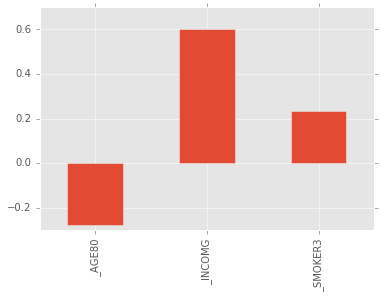

In [7]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(lr_clf.coef_[0],index=df_reduced.columns)
weights.plot(kind='bar')
plt.show()

At this point it would make sense to remove variables that are highly related to one another or ones that are irrelevant and keep going with the weights analysis. For this analysis, we removed GENHLTH above, which is what we're trying to predict, and have as the 'health' variable in a seperate dataframe.


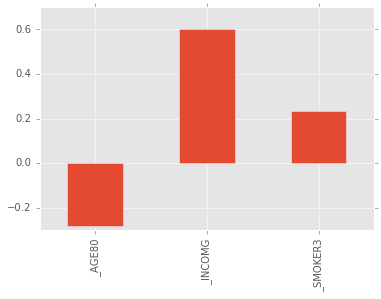

In [8]:

# you can also apply the StandardScaler function insied of the validation loop 
#  but this requires the use of PipeLines in scikit. Here is an example, but we will go over more 
#  thorough examples later in class

from sklearn.pipeline import Pipeline

std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05) 

# create the pipline
piped_object = Pipeline([('scale', std_scl), ('logit_model', lr_clf)])

# run the pipline crossvalidated
for iter_num, (train_indices, test_indices) in enumerate(cv_object):
    piped_object.fit(X[train_indices],y[train_indices])  # train object
    
# it is a little odd getting trained objects from a  pipeline:
trained_model_from_pipeline = piped_object.named_steps['logit_model']

# now look at the weights
weights = pd.Series(trained_model_from_pipeline.coef_[0],index=df_reduced.columns)
weights.plot(kind='bar')
plt.show()

## Support Vector Machine

In [9]:
# We know this takes a while to run, so we'll benchmark it for giggles
import datetime
starttime = datetime.datetime.now()
print starttime


2016-06-27 21:24:22.020000


In [10]:
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object: 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

print datetime.datetime.now()


2016-06-27 21:24:22.374000


In [11]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

print "start training.", datetime.datetime.now()

# train the model just as before
svm_clf = SVC(C=0.05, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print ("accuracy:", acc) 
print (conf)

print datetime.datetime.now()

start training.
('accuracy:', 0.63905333210821313)
[[19858 17283]
 [10215 28827]]
2016-06-27 22:12:27.966000


In [12]:
# look at the support vectors
print (svm_clf.support_vectors_.shape)
print (svm_clf.support_.shape)
print (svm_clf.n_support_) 

(230323L, 3L)
(230323L,)
[115160 115163]


[[ -3.85130301e-04   9.76492234e-01   2.21432013e-04]]


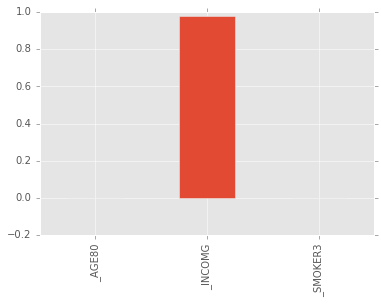

In [13]:
# if using linear kernel, these make sense to look at (not otherwise, why?)
print svm_clf.coef_
weights = pd.Series(svm_clf.coef_[0],index=df_reduced.columns)
weights.plot(kind='bar')

In [14]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)


# make a dataframe of the training data
df_tested_on = df_reduced.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['health'] = y[svm_clf.support_] # add back in the 'health' Column to the pandas dataframe
df_reduced['health'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230323 entries, 9550 to 351011
Data columns (total 4 columns):
_AGE80      230323 non-null int64
_INCOMG     230323 non-null float64
_SMOKER3    230323 non-null float64
health      230323 non-null category
dtypes: category(1), float64(2), int64(1)
memory usage: 7.2 MB


C:\Users\rahnl\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('** Staring', datetime.datetime(2016, 6, 27, 22, 15, 25, 433000))
2016-06-27 22:16:44.003000


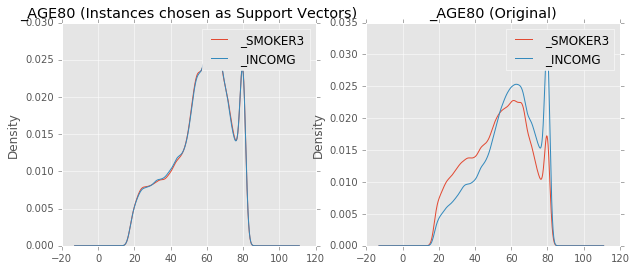

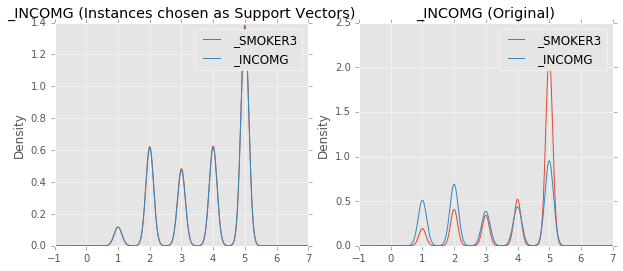

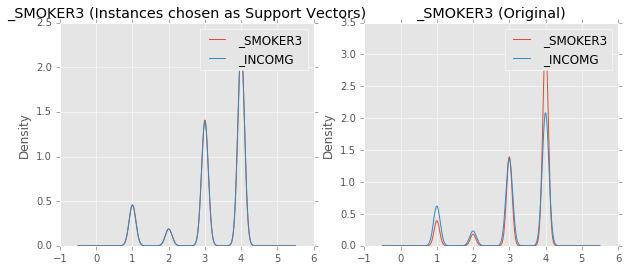

In [18]:
# now lets see the statistics of these attributes
starttime = datetime.datetime.now() 
print ("** Staring", starttime)
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['health'])
df_grouped = df_reduced.groupby(['health'])

# plot KDE of Different variables
vars_to_plot = ['_AGE80', '_INCOMG','_SMOKER3']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['_SMOKER3','_INCOMG'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['_SMOKER3','_INCOMG'])
    plt.title(v+' (Original)')

print datetime.datetime.now()